# **KM Master Discrepancy Detection System - Analysis**

![Python Code](https://img.shields.io/badge/Python-Code-blue?logo=python&logoColor=white)
![Sheets API](https://img.shields.io/badge/Google_Sheets-API-34A853?logo=googlesheets&logoColor=white)

### **Project Context**

KM Master represents the **round-trip distance** between Operating Points (OP) and Stores, which is critical for calculating **UJP** (Uang Jalan Pengiriman - transportation costs).

**Why This Matters:**
- **Underestimated distances** → Operational problems, driver dissatisfaction
- **Overestimated distances** → Fraud opportunities, inflated costs

With **thousands of stores**, manually validating all KM Master entries is impractical. The operations team needs to **prioritize** which entries to validate first.

# **Setup and Libraries**

In [1]:
# setup source path
import sys
import os

# add source directory to python path for custom modules
src_path = os.path.join(os.getcwd(), "..", "src")

if src_path not in sys.path:
    sys.path.append(src_path)
    print(f"Added {src_path[34:]} to sys.path")
else:
    print(f"{src_path[34:]} already in sys.path")

Added km-master-discrepancy-detection-system\notebooks\..\src to sys.path


In [2]:
# initialize configuration and environment variables
import config
from dotenv import load_dotenv
load_dotenv(config.ENV_PATH)

# set hide_values parameter
# config.HIDE_VALUES = False  # uncomment to show numeric values

# import custom modules
from google_sheets_io import sheets_loader, sheets_updater
from utils import (
    setup_logging, mask_numeric_value, DataTracker, result_summary, 
    plot_outlier, filter_iqr, pivot_and_remove_low_freq_stores,
    get_unique_stores, get_diff_unique_stores
)

# import common libraries
import pandas as pd
import numpy as np
import logging
import time
import zipfile

pd.set_option('future.no_silent_downcasting', True) # to suppress warning messages

# setup logging
setup_logging()
logger = logging.getLogger(__name__)

# display configuration
if config.HIDE_VALUES:
    logger.info(f"Hiding numeric values with '*' symbol")
else:
    logger.info("Showing numeric values")

2025-12-19 07:04:34 - __main__ - INFO - Hiding numeric values with '*' symbol


# **Data**

This notebook using data result from 01-Data-Preprocessing.ipynb

### **Key Columns:**
  - `Tgl SLA` - Delivery date
  - `Nomor SPJ` - Delivery records / Waybill. One `SPJ` may contain several `Toko`
  - `OP` - Operating Point Code
  - `Toko` - Store code
  - `KM Master` - Master distance (round-trip) for each `Toko`
  - `KM Tempuh` - Actual distance traveled (round-trip) for each `SPJ`
  - `KM Max` - Maximum value of `KM Master` for each `SPJ`
  - `KM Deviation (%)` - Deviation value between `KM Tempuh` and `KM Master` in %
  - `Kode Zona` - Zone code
  - `Kecamatan`, `Kota`, `Provinsi` - Geographic info

<br>

> **Disclaimer:** <br>Due to confidentiality, actual data **is not included** in this repository. <br>Some values are replaced with the `*` symbol.

<br>

> **Notes:** <br>For convenience, this project will using term **Unique Store** to label unique `OP` and `Toko` combination

In [3]:
# define path for all data
all_data_path = os.path.join(config.DATA_PATH, "clean", "df_all_data.csv")

# read all data
start_time = time.time()
df_all_data = pd.read_csv(all_data_path)
load_time = time.time() - start_time

logger.info(f"Loaded {mask_numeric_value(f'{len(df_all_data[config.UNIQUE_STORE_COLUMNS].drop_duplicates()):,}')} unique stores of all data in {load_time:.2f} secs")

2025-12-19 07:04:45 - __main__ - INFO - Loaded **,*** unique stores of all data in 10.50 secs


# **KM Master Method**

Explain method

In [4]:
# base data using all data
df_km_master = df_all_data.copy()
# for subsequent labeling, df_km_master is shortened to df_kmr

In [5]:
# track KM Master method
tracker_km_master = DataTracker("KM Master Method")
tracker_km_master.track(
    df_km_master, step_name="Initial Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS # default ['OP', 'Toko']
)

2025-12-19 07:04:46 - utils - INFO - Initialized DataTracker for: [KM Master Method]
2025-12-19 07:04:46 - utils - INFO - [KM Master Method] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


## **A. Main Method**

### **1. Remove KM Master Outside Treshold**

In [6]:
# get data with KM Master outside or equal to treshold for giving recommendation
min_km_master = 1
max_km_master = 1800
df_kmr_xoutside = df_km_master[
    (df_km_master['KM Master'] < min_km_master) 
    | (df_km_master['KM Master'] > max_km_master)
]

# drop duplicate rows and sort based on OP and Toko
df_kmr_xoutside = df_kmr_xoutside.drop_duplicates(
    subset=config.UNIQUE_STORE_COLUMNS
    ).sort_values(by=config.UNIQUE_STORE_COLUMNS
).reset_index(drop=True)

# only keep relevant columns
df_kmr_xoutside = df_kmr_xoutside[['OP', 'Kode Zona', 'Toko', 'KM Master']]

# add recommendation column
df_kmr_xoutside['KM Master Rekomendasi'] = np.nan

tracker_km_master.track(
    df_kmr_xoutside, step_name="Remove KM Master Outside Treshold", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:04:46 - utils - INFO - [KM Master Method] Step: Remove KM Master Outside Treshold | Counts: * | Change: -**,*** (-99.99%) | Retention: 0.01% | Step Time: 0.85s | Cumulative Time: 0.86s


### **2. Give Recommendation**

In [7]:
# get data from google sheets for recommendation
worksheet = sheets_loader(sheets_url=os.getenv('SHEETS_URL')).worksheet(config.UPDATED_WORKSHEET)
df_kmr_rec = pd.DataFrame(worksheet.get_all_records())
df_kmr_rec = df_kmr_rec.replace("", np.nan).infer_objects(copy=False)
logger.info(f"Loaded {mask_numeric_value(f'{len(df_kmr_rec):,}')} rows of google sheets recommendation data")

# check if google sheet data is empty
if df_kmr_rec.empty:
    df_kmr_rec = pd.DataFrame(columns=['OP', 'Kode Zona', 'Toko', 'KM Master Rekomendasi'])

# check the data
check_content = df_kmr_xoutside[['OP', 'Kode Zona', 'Toko']].isin(
    df_kmr_rec[['OP', 'Kode Zona', 'Toko']]
).all().all()
check_recommendation = df_kmr_rec['KM Master Rekomendasi'].isna().sum()

if check_content: # if df_kmr_xoutside content is in df_kmr_rec
    if check_recommendation > 0: # if there is OP and Store with no recommendation
        # update google sheet data with no KM Master recommendation
        df_kmr_xoutside = df_kmr_xoutside.where(df_kmr_xoutside.notna(), "")
        sheets_updater(sheets_url=os.getenv('SHEETS_URL'), df=df_kmr_xoutside)
        logger.warning(f"Update {config.UPDATED_WORKSHEET} with no KM Master recommendation")
        # hide values if configured
        if config.HIDE_VALUES:
            raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')[:30]} [Redacted]")
        else:
            raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')}")
    else:
        logger.info(f"Data in {config.UPDATED_WORKSHEET} is completed")
else:
    # update google sheet data with no KM Master recommendation
    df_kmr_xoutside = df_kmr_xoutside.where(df_kmr_xoutside.notna(), "")
    sheets_updater(sheets_url=os.getenv('SHEETS_URL'), df=df_kmr_xoutside)
    logger.warning(f"Update {config.UPDATED_WORKSHEET} with no KM Master recommendation")
    # hide values if configured
    if config.HIDE_VALUES:
        raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')[:30]} [Redacted]")
    else:
        raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')}")

tracker_km_master.track(
    df_kmr_rec, step_name="Give KM Master Recommendation", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:04:47 - google_sheets_io - INFO - Loading Google Sheets from URL: https://docs.google.com/spread [Redacted]...
2025-12-19 07:04:47 - google_sheets_io - INFO - Credentials loaded successfully
2025-12-19 07:04:47 - google_sheets_io - INFO - Google Sheets API authorized
2025-12-19 07:04:49 - google_sheets_io - INFO - Sheet opened successfully
2025-12-19 07:04:50 - __main__ - INFO - Loaded * rows of google sheets recommendation data
2025-12-19 07:04:50 - __main__ - INFO - Data in Rekomendasi Manual KM Master is completed
2025-12-19 07:04:50 - utils - INFO - [KM Master Method] Step: Give KM Master Recommendation | Counts: * | Change: +0 (+0.00%) | Retention: 0.01% | Step Time: 3.60s | Cumulative Time: 4.46s


> **Notes:** <br>If there is no recommendation or different data for KM Master method in google sheet, it will give error and need to get recommendation based on manual works. For example, you may look at this picture:

![pict](../img/km_master_method_fail_example_v2.png)

## **B. KM Master Result**

In [8]:
# save the result
df_kmr_final = df_kmr_rec.copy()
unique_store_km_master = df_kmr_final[config.UNIQUE_STORE_COLUMNS].drop_duplicates()

# format data
df_kmr_final['Metode'] = 'KM Master'
df_kmr_final = df_kmr_final.rename(columns={'KM Master': 'KM Master Saat Ini'})
df_kmr_final = df_kmr_final[
    ['OP', 'Kode Zona', 'Toko', 'KM Master Saat Ini', 'KM Master Rekomendasi', 'Metode']
]

tracker_km_master.track(
    df_kmr_final, step_name="Final Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:04:50 - utils - INFO - [KM Master Method] Step: Final Unique Store | Counts: * | Change: +0 (+0.00%) | Retention: 0.01% | Step Time: 0.03s | Cumulative Time: 4.48s


In [9]:
# show summary
tracker_km_master.summary()

2025-12-19 07:04:50 - utils - INFO - [KM Master Method] DataTracker summary generated for 4 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Remove KM Master Outside Treshold,*,"-**,***",-99.99,0.01,0.85,0.86
2,Give KM Master Recommendation,*,+0,+0.00,0.01,3.60,4.46
3,Final Unique Store,*,+0,+0.00,0.01,0.03,4.48


# **KM Tempuh Method**

Explain method

In [10]:
# base data using all data
df_km_tempuh = df_all_data.copy()
# for subsequent labeling, df_km_tempuh is shortened to df_kth

In [11]:
# track KM Tempuh method
tracker_km_tempuh = DataTracker("KM Tempuh Method")
tracker_km_tempuh.track(
    df_km_tempuh, step_name="Initial Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:04:51 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method]
2025-12-19 07:04:51 - utils - INFO - [KM Tempuh Method] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


In [12]:
# load data exclude unique store from km master method result
df_kth_xkmr = (
    df_km_tempuh
    .merge(
        unique_store_km_master, on=config.UNIQUE_STORE_COLUMNS, 
        how='left', indicator=True
    )
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)

tracker_km_tempuh.track(
    df_kth_xkmr, step_name="Exclude KM Master Recommended Stores", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:04:57 - utils - INFO - [KM Tempuh Method] Step: Exclude KM Master Recommended Stores | Counts: **,*** | Change: -* (-0.01%) | Retention: 99.99% | Step Time: 5.38s | Cumulative Time: 5.39s


## **A. Separation Data**

In [13]:
# separate df_kth_xkmr into two data category

# data with km max = 1 (C1)
df_kth_c1 = df_kth_xkmr[df_kth_xkmr['KM Max'] == 1]

# data with km max != 1 (C2)
df_kth_c2 = df_kth_xkmr[df_kth_xkmr['KM Max'] != 1]

Explain there is still intersect of unique store betwwen two dataset category and we need to remove

In [14]:
# search intersect of unique store between two data category
unique_store_c1 = df_kth_c1[config.UNIQUE_STORE_COLUMNS].drop_duplicates()
unique_store_c2 = df_kth_c2[config.UNIQUE_STORE_COLUMNS].drop_duplicates()
intersect_unique_store_c1_c2 = pd.merge(
    unique_store_c1, unique_store_c2,
    on=config.UNIQUE_STORE_COLUMNS, how='inner'
)

# remove df_kth_c2 from intersect data
df_kth_c2 = (
    df_kth_c2
    .merge(
        intersect_unique_store_c1_c2, on=config.UNIQUE_STORE_COLUMNS, 
        how='left', indicator=True
    )
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)

# save unique store of KM Tempuh and C2 data for validate
unique_store_km_tempuh = df_kth_xkmr[config.UNIQUE_STORE_COLUMNS].drop_duplicates()
unique_store_c2 = df_kth_c2[config.UNIQUE_STORE_COLUMNS].drop_duplicates()

# validate data
if len(intersect_unique_store_c1_c2) == 0:
    logger.info("No intersect unique store between two data category")
    tracker_km_tempuh.track(
        df_kth_xkmr, step_name="Separate Data", 
        rows_unique=config.UNIQUE_STORE_COLUMNS
    )
else:
  if len(unique_store_c1) + len(unique_store_c2) == len(unique_store_km_tempuh):
    logger.info("Total data is appropriate. Separation data is success!")
    tracker_km_tempuh.track(
        df_kth_xkmr, step_name="Separate Data", 
        rows_unique=config.UNIQUE_STORE_COLUMNS
    )
  else:
    logger.error("Total data doesn't match. Separation data is failed.")

2025-12-19 07:05:05 - __main__ - INFO - Total data is appropriate. Separation data is success!
2025-12-19 07:05:06 - utils - INFO - [KM Tempuh Method] Step: Separate Data | Counts: **,*** | Change: +0 (+0.00%) | Retention: 99.99% | Step Time: 9.21s | Cumulative Time: 14.60s


## **B. KM Max = 1 Category**

In [15]:
# track KM Tempuh C1 method
tracker_km_tempuh_c1 = DataTracker("KM Tempuh Method (KM Max = 1)")
tracker_km_tempuh_c1.track(
    df_kth_c1, step_name="Initial Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:06 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method (KM Max = 1)]
2025-12-19 07:05:06 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Initial Unique Store | Counts: *** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


### **1. Remove Outlier**

2025-12-19 07:05:06 - utils - INFO - Plotting outlier detection for 'KM Tempuh Method (KM Max = 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max = 1)'
2025-12-19 07:05:06 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=1.5, upper=1.5
2025-12-19 07:05:06 - utils - INFO - IQR filter applied on 'KM Deviation (%)': * rows removed (0.06%)


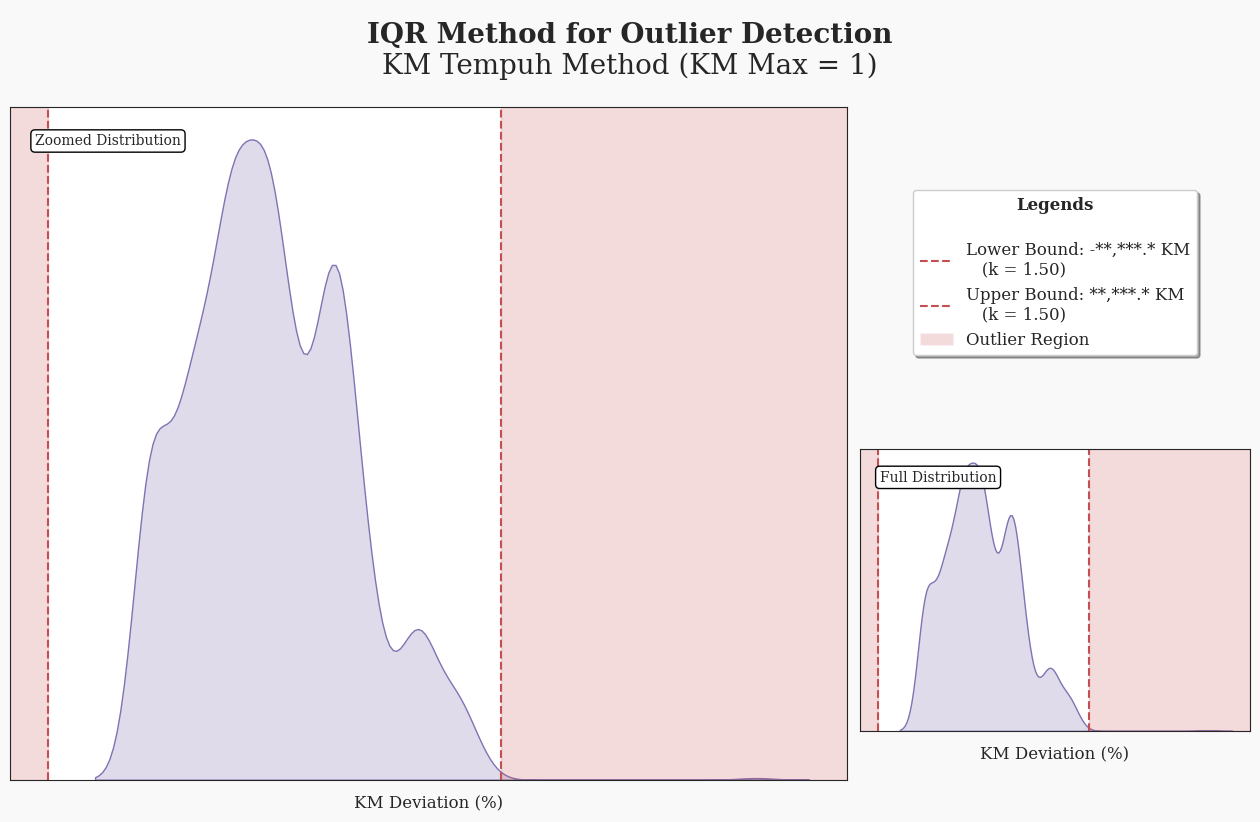

2025-12-19 07:05:06 - utils - INFO - Outlier detection plot generated for 'KM Tempuh Method (KM Max = 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max = 1)'


In [16]:
# show outlier plot to determine treshold for KM Tempuh C1 method
plot_outlier(df=df_kth_c1, name="KM Tempuh Method (KM Max = 1)")

Give explain about the plot

In [17]:
# remove outlier using IQR method
df_kth_c1_xoutlier = filter_iqr(df_kth_c1)[0]

tracker_km_tempuh_c1.track(
    df_kth_c1_xoutlier, step_name="Remove Outlier", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:07 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=1.5, upper=1.5
2025-12-19 07:05:07 - utils - INFO - IQR filter applied on 'KM Deviation (%)': * rows removed (0.06%)
2025-12-19 07:05:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Remove Outlier | Counts: *** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.57s | Cumulative Time: 0.58s


### **2. Remove Correct Store**

In [18]:
# remove correct store based on operational knowledge
df_kth_c1_xcorrect = df_kth_c1_xoutlier[
    df_kth_c1_xoutlier['KM Deviation (%)'].abs() > config.RIGHT_DEV_KM_TRESHOLD # default 3%
].copy()

logger.info(f"Removed correct store with treshold {config.RIGHT_DEV_KM_TRESHOLD}% of KM Deviation")

tracker_km_tempuh_c1.track(
    df_kth_c1_xcorrect, step_name="Remove Correct Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:07 - __main__ - INFO - Removed correct store with treshold 3.0% of KM Deviation
2025-12-19 07:05:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Remove Correct Store | Counts: *** | Change: -* (-2.59%) | Retention: 97.41% | Step Time: 0.03s | Cumulative Time: 0.60s


Explain why 3% using BBM Ratio with Rp6800 per liter

### **3. Pivot and Remove Low Visit Frequency Stores**

In [19]:
# pivot and remove store with low visit frequency
df_kth_c1_pivot = pivot_and_remove_low_freq_stores(
    df=df_kth_c1_xcorrect
)

tracker_km_tempuh_c1.track(
    df_kth_c1_pivot, step_name="Pivot & Remove Low Visit Frequency Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:07 - utils - INFO - Pivot table created: *** unique stores
2025-12-19 07:05:07 - utils - INFO - After removing low-frequency stores with frequency <= 1: *** unique stores
2025-12-19 07:05:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Pivot & Remove Low Visit Frequency Store | Counts: *** | Change: -*** (-40.86%) | Retention: 57.61% | Step Time: 0.05s | Cumulative Time: 0.65s


### **4. Finalize Data & Summary**

In [20]:
# remove if there are KM Tempuh equal to KM Master because of rounding
# it is because mean of KM Tempuh will be KM Master Recommendation
df_kth_c1_final = df_kth_c1_pivot[
    ~(df_kth_c1_pivot['KM Tempuh'] == df_kth_c1_pivot['KM Master'])
]

tracker_km_tempuh_c1.track(
    df_kth_c1_final, step_name="Final Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Final Unique Store | Counts: *** | Change: +0 (+0.00%) | Retention: 57.61% | Step Time: 0.02s | Cumulative Time: 0.67s


In [21]:
# show summary
tracker_km_tempuh_c1.summary()

2025-12-19 07:05:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] DataTracker summary generated for 5 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,***,+0,+0.00,100.00,0.00,0.00
1,Remove Outlier,***,+0,+0.00,100.00,0.57,0.58
2,Remove Correct Store,***,-*,-2.59,97.41,0.03,0.60
3,Pivot & Remove Low Visit Frequency Store,***,-***,-40.86,57.61,0.05,0.65
4,Final Unique Store,***,+0,+0.00,57.61,0.02,0.67


## **C. KM Max != 1 Category**

In [22]:
# track KM Tempuh C2 method
tracker_km_tempuh_c2 = DataTracker("KM Tempuh Method (KM Max != 1)")
tracker_km_tempuh_c2.track(
    df_kth_c2, step_name="Initial Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:07 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method (KM Max != 1)]
2025-12-19 07:05:07 - utils - INFO - [KM Tempuh Method (KM Max != 1)] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


### **1. Keep Longest KM Master Stores per Waybill**

In [23]:
# remove KM Master is not equal to KM Max
df_kth_c2_max = df_kth_c2[df_kth_c2['KM Master'] == df_kth_c2['KM Max']].copy()

tracker_km_tempuh_c2.track(
    df_kth_c2_max, step_name="Keep Longest KM Master Stores per Waybill", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:08 - utils - INFO - [KM Tempuh Method (KM Max != 1)] Step: Keep Longest KM Master Stores per Waybill | Counts: **,*** | Change: -**,*** (-38.06%) | Retention: 61.94% | Step Time: 1.05s | Cumulative Time: 1.05s


### **2. Remove Outlier**

2025-12-19 07:05:08 - utils - INFO - Plotting outlier detection for 'KM Tempuh Method (KM Max != 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max != 1)'
2025-12-19 07:05:08 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=2, upper=9
2025-12-19 07:05:08 - utils - INFO - IQR filter applied on 'KM Deviation (%)': **,*** rows removed (3.37%)


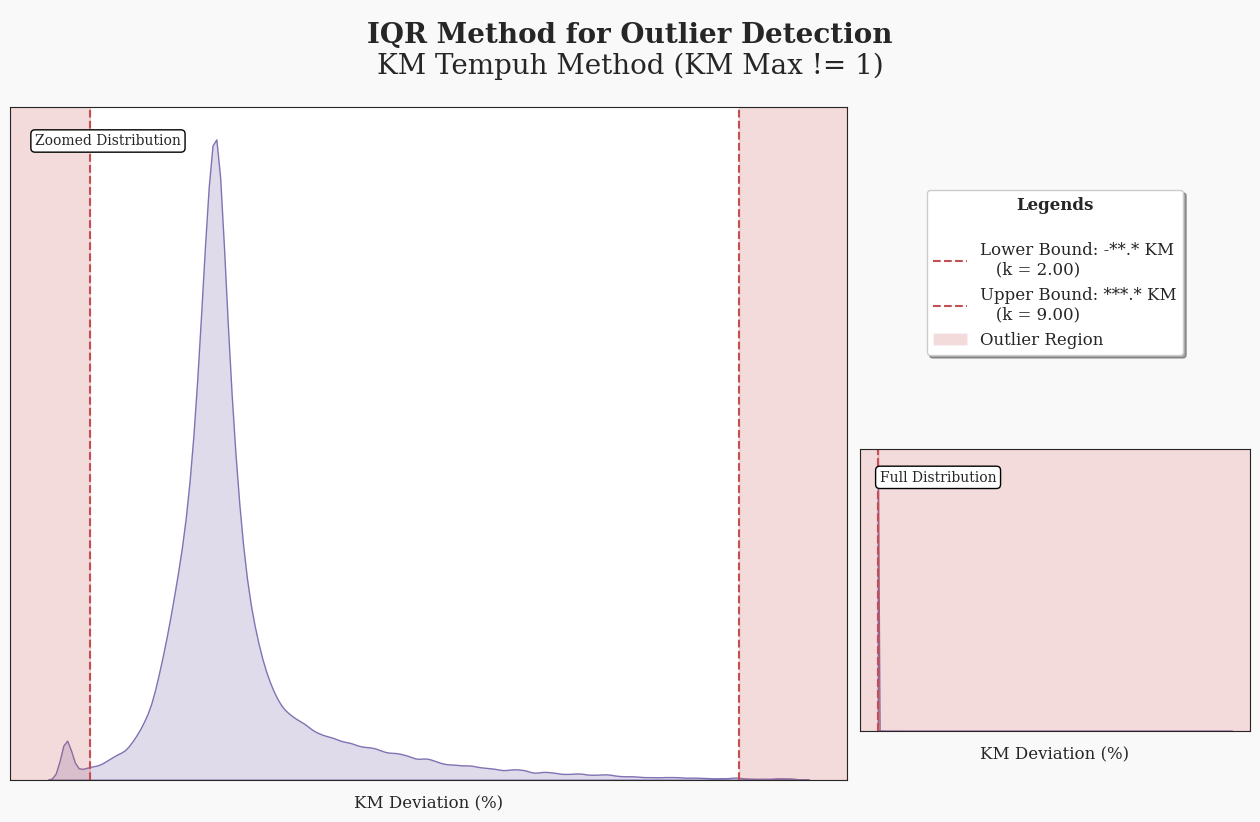

2025-12-19 07:05:30 - utils - INFO - Outlier detection plot generated for 'KM Tempuh Method (KM Max != 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max != 1)'


In [24]:
# show outlier plot to determine treshold for KM Tempuh C1 method
plot_outlier(
    df=df_kth_c2_max, name="KM Tempuh Method (KM Max != 1)", 
    lower_constant=2, upper_constant=9
)

In [25]:
# remove outlier using IQR method
df_kth_c2_xoutlier = filter_iqr(df_kth_c2_max, lower_constant=2, upper_constant=9)[0]

tracker_km_tempuh_c2.track(
    df_kth_c2_xoutlier, step_name="Remove Outlier", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:30 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=2, upper=9
2025-12-19 07:05:30 - utils - INFO - IQR filter applied on 'KM Deviation (%)': **,*** rows removed (3.37%)
2025-12-19 07:05:30 - utils - INFO - [KM Tempuh Method (KM Max != 1)] Step: Remove Outlier | Counts: **,*** | Change: -*** (-2.88%) | Retention: 60.16% | Step Time: 22.29s | Cumulative Time: 23.35s


### **3. Remove Correct Store**

In [26]:
# remove correct store based on operational knowledge
df_kth_c2_xcorrect = df_kth_c2_xoutlier[
    df_kth_c2_xoutlier['KM Deviation (%)'].abs() > config.RIGHT_DEV_KM_TRESHOLD # default 3%
].copy()

logger.info(f"Removed correct store with treshold {config.RIGHT_DEV_KM_TRESHOLD}% of KM Deviation")

tracker_km_tempuh_c2.track(
    df_kth_c2_xcorrect, step_name="Remove Correct Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:31 - __main__ - INFO - Removed correct store with treshold 3.0% of KM Deviation
2025-12-19 07:05:31 - utils - INFO - [KM Tempuh Method (KM Max != 1)] Step: Remove Correct Store | Counts: **,*** | Change: -*** (-1.48%) | Retention: 59.27% | Step Time: 0.52s | Cumulative Time: 23.87s


### **4. Pivot and Remove Low Visit Frequency Stores**

In [27]:
# pivot and remove store with low visit frequency
df_kth_c2_pivot = pivot_and_remove_low_freq_stores(
    df=df_kth_c2_xcorrect
)

tracker_km_tempuh_c2.track(
    df_kth_c2_pivot, step_name="Pivot & Remove Low Visit Frequency Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:31 - utils - INFO - Pivot table created: **,*** unique stores
2025-12-19 07:05:31 - utils - INFO - After removing low-frequency stores with frequency <= 1: **,*** unique stores
2025-12-19 07:05:31 - utils - INFO - [KM Tempuh Method (KM Max != 1)] Step: Pivot & Remove Low Visit Frequency Store | Counts: **,*** | Change: -*,*** (-11.28%) | Retention: 52.58% | Step Time: 0.79s | Cumulative Time: 24.66s


### **5. Finalize Data & Summary**

In [28]:
# remove if there are KM Tempuh equal to KM Master because of rounding
# it is because mean of KM Tempuh will be KM Master Recommendation
df_kth_c2_final = df_kth_c2_pivot[
    ~(df_kth_c2_pivot['KM Tempuh'] == df_kth_c2_pivot['KM Master'])
]

tracker_km_tempuh_c2.track(
    df_kth_c2_final, step_name="Final Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:31 - utils - INFO - [KM Tempuh Method (KM Max != 1)] Step: Final Unique Store | Counts: **,*** | Change: -*** (-2.58%) | Retention: 51.22% | Step Time: 0.03s | Cumulative Time: 24.69s


In [29]:
# show summary
tracker_km_tempuh_c2.summary()

2025-12-19 07:05:31 - utils - INFO - [KM Tempuh Method (KM Max != 1)] DataTracker summary generated for 6 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Keep Longest KM Master Stores per Waybill,"**,***","-**,***",-38.06,61.94,1.05,1.05
2,Remove Outlier,"**,***",-***,-2.88,60.16,22.29,23.35
3,Remove Correct Store,"**,***",-***,-1.48,59.27,0.52,23.87
4,Pivot & Remove Low Visit Frequency Store,"**,***","-*,***",-11.28,52.58,0.79,24.66
5,Final Unique Store,"**,***",-***,-2.58,51.22,0.03,24.69


## **D. Outlier Category**

In [30]:
# get outlier data from both category

# C1 outlier data
mask_c1_outlier = ~df_kth_c1.set_index(config.UNIQUE_STORE_COLUMNS).index.isin(
    df_kth_c1_xoutlier.set_index(config.UNIQUE_STORE_COLUMNS).index
)  
df_kth_c1_outlier = df_kth_c1[mask_c1_outlier].copy()

# C2 outlier data
mask_c2_outlier = ~df_kth_c2_max.set_index(config.UNIQUE_STORE_COLUMNS).index.isin(
    df_kth_c2_xoutlier.set_index(config.UNIQUE_STORE_COLUMNS).index
)
df_kth_c2_outlier = df_kth_c2_max[mask_c2_outlier].copy()

# concat outlier data
df_kth_outlier = pd.concat([df_kth_c1_outlier, df_kth_c2_outlier], ignore_index=True)

In [31]:
# track outlier data
tracker_km_tempuh_outlier = DataTracker("KM Tempuh Method (Outlier)")
tracker_km_tempuh_outlier.track(
    df_kth_outlier, step_name="Outlier Data", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:32 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method (Outlier)]
2025-12-19 07:05:32 - utils - INFO - [KM Tempuh Method (Outlier)] Step: Outlier Data | Counts: *** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.01s | Cumulative Time: 0.01s


### **1. Pivot and Remove Low Visit Frequency Stores**

In [32]:
# pivot and remove store with low visit frequency
df_kth_outlier_pivot = pivot_and_remove_low_freq_stores(
    df=df_kth_outlier,
    count_toko=3 # use more strict treshold for outlier data
)

tracker_km_tempuh_outlier.track(
    df_kth_outlier_pivot, step_name="Pivot & Remove Low Visit Frequency Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:32 - utils - INFO - Pivot table created: *** unique stores
2025-12-19 07:05:32 - utils - INFO - After removing low-frequency stores with frequency <= 3: *** unique stores
2025-12-19 07:05:32 - utils - INFO - [KM Tempuh Method (Outlier)] Step: Pivot & Remove Low Visit Frequency Store | Counts: *** | Change: -*** (-81.21%) | Retention: 18.79% | Step Time: 0.04s | Cumulative Time: 0.04s


### **2. Finalize Data & Summary**

In [33]:
# remove if there are KM Tempuh equal to KM Master because of rounding
# it is because mean of KM Tempuh will be KM Master Recommendation
df_kth_outlier_final = df_kth_outlier_pivot[
    ~(df_kth_outlier_pivot['KM Tempuh'] == df_kth_outlier_pivot['KM Master'])
]

tracker_km_tempuh_outlier.track(
    df_kth_outlier_final, step_name="Final Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:32 - utils - INFO - [KM Tempuh Method (Outlier)] Step: Final Unique Store | Counts: *** | Change: +0 (+0.00%) | Retention: 18.79% | Step Time: 0.01s | Cumulative Time: 0.06s


In [34]:
# show summary
tracker_km_tempuh_outlier.summary()

2025-12-19 07:05:32 - utils - INFO - [KM Tempuh Method (Outlier)] DataTracker summary generated for 3 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Outlier Data,***,+0,+0.00,100.00,0.01,0.01
1,Pivot & Remove Low Visit Frequency Store,***,-***,-81.21,18.79,0.04,0.04
2,Final Unique Store,***,+0,+0.00,18.79,0.01,0.06


## **E. KM Tempuh Result**

In [35]:
# concat final data from KM Tempuh C1, C2, and Outlier
df_kth_final = pd.concat(
    [df_kth_c1_final, df_kth_c2_final, df_kth_outlier_final],
    ignore_index=True
)

# format dataframe
df_kth_final.rename(columns={
    'KM Tempuh': 'KM Master Rekomendasi','KM Master': 'KM Master Saat Ini'
}, inplace=True)
df_kth_final.drop(columns=['Freq Toko'], inplace=True)
df_kth_final = df_kth_final[
    ['OP', 'Kode Zona', 'Toko', 'KM Master Saat Ini', 'KM Master Rekomendasi']
]
df_kth_final['Metode'] = 'KM Tempuh'

# check if there are duplicate unique store
if df_kth_final.duplicated(subset=config.UNIQUE_STORE_COLUMNS).any():
    logger.exception("There are duplicate unique store in final KM Tempuh data")
    raise ValueError("There are duplicate unique store in final KM Tempuh data")

# save processed unique store list for next method
# km tempuh method result unique stores
list_unique_store_km_tempuh = get_unique_stores(df_kth_final)
# correct unique stores from each category
list_unique_store_c1_correct = get_diff_unique_stores(df_kth_c1_xoutlier, df_kth_c1_xcorrect)
list_unique_store_c2_correct = get_diff_unique_stores(df_kth_c2_xoutlier, df_kth_c2_xcorrect)
# identical km master recommendation with current km master unique stores
list_unique_store_c1_identical = get_diff_unique_stores(df_kth_c1_pivot, df_kth_c1_final)
list_unique_store_c2_identical = get_diff_unique_stores(df_kth_c2_pivot, df_kth_c2_final)
list_unique_store_outlier_identical = get_diff_unique_stores(
    df_kth_outlier_pivot, df_kth_outlier_final
)
# combine result
list_unique_store_km_tempuh_processed = (
    list_unique_store_km_tempuh 
    + list_unique_store_c1_correct + list_unique_store_c2_correct
    + list_unique_store_c1_identical + list_unique_store_c2_identical 
    + list_unique_store_outlier_identical
)

tracker_km_tempuh.track(
    df_kth_final, step_name="Final Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:33 - utils - INFO - [KM Tempuh Method] Step: Final Unique Store | Counts: **,*** | Change: -**,*** (-48.40%) | Retention: 51.59% | Step Time: 27.88s | Cumulative Time: 42.48s


In [36]:
# show summary
tracker_km_tempuh.summary()

2025-12-19 07:05:33 - utils - INFO - [KM Tempuh Method] DataTracker summary generated for 4 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Exclude KM Master Recommended Stores,"**,***",-*,-0.01,99.99,5.38,5.39
2,Separate Data,"**,***",+0,+0.00,99.99,9.21,14.60
3,Final Unique Store,"**,***","-**,***",-48.40,51.59,27.88,42.48


# **Master Zona Method**

Explain method (+ why using df_km_tempuh data instead of remove list_unique_store_km_tempuh_processed first (because it will decrease data for giving recommendation in master zona method))

In [37]:
# base data using km tempuh data
df_master_zona = df_kth_xkmr.copy()
# for subsequent labeling, df_master_zona is shortened to df_mzn

In [38]:
# track Master Zona method
tracker_master_zona = DataTracker("Master Zona Method")
tracker_master_zona.track(
    df_master_zona, step_name="Initial Unique Store", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:33 - utils - INFO - Initialized DataTracker for: [Master Zona Method]
2025-12-19 07:05:34 - utils - INFO - [Master Zona Method] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


## **A. Main Method**

### **1. Keep Selected Provinces**

Explain why we need to filter based on Provinsi because there are province with different route schema like more longer distance, road infrastructure is still not efficient, etc

In [39]:
# filter using 'Provinsi' to analyze data with similar condition
list_province = os.getenv('INCLUDE_PROVINCES').split(',')
# we want to compare with km tempuh method result later
df_mzn_province = df_master_zona[df_master_zona['Provinsi'].isin(list_province)].copy()

tracker_master_zona.track(
    df_mzn_province, step_name="Keep Selected Province", 
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:36 - utils - INFO - [Master Zona Method] Step: Keep Selected Province | Counts: **,*** | Change: -*,*** (-13.09%) | Retention: 86.91% | Step Time: 1.89s | Cumulative Time: 1.89s


### **2. Calculate Store Visit Frequency**

In [40]:
# add store visits frequency column
df_store_freq = (
    df_mzn_province
    .groupby(['Kode Zona', 'Toko'])['Toko']
    .count()
    .reset_index(name='Freq Toko')
)

df_mzn_freq = df_mzn_province.merge(
    df_store_freq,
    on=['Kode Zona', 'Toko'],
    how='left'
)   

# add max store visits frequency per zone column
df_store_freq_max = (
    df_store_freq
    .groupby(['Kode Zona'])['Freq Toko']
    .max()
    .reset_index(name='Freq Toko Max')
)

df_mzn_freq = df_mzn_freq.merge(
    df_store_freq_max,
    on=['Kode Zona'],
    how='left'
)

tracker_master_zona.track(df_mzn_freq, step_name="Add Store Visit Frequency Column", rows_unique=config.UNIQUE_STORE_COLUMNS)

2025-12-19 07:05:41 - utils - INFO - [Master Zona Method] Step: Add Store Visit Frequency Column | Counts: **,*** | Change: +0 (+0.00%) | Retention: 86.91% | Step Time: 4.86s | Cumulative Time: 6.75s


### **3. Give Recommendation**

In [41]:
# remove freq toko is not equal to freq toko max
df_mzn_freq_max = df_mzn_freq[
    df_mzn_freq['Freq Toko'] == df_mzn_freq['Freq Toko Max']
].copy()

# remove store outside treshold of visit frequency
df_mzn_rec = df_mzn_freq_max[
    df_mzn_freq_max['Freq Toko'] > config.MZN_FREQ_TOKO_THRESHOLD # default 1 time visit
].copy()

# pivot for giving recommendation based on median of KM Tempuh per zone
df_mzn_pivot = (
    df_mzn_rec
    .groupby(['OP', 'Toko', 'Kode Zona'], as_index=False)['KM Master']
    .mean()
    .rename(columns={'KM Master': 'KM Master Rekomendasi'})
)

# replace recommendation with km tempuh method result if exist
df_mzn_pivot = df_mzn_pivot.merge(
    df_kth_final[['OP', 'Toko', 'Kode Zona', 'KM Master Rekomendasi']],
    on=['OP', 'Toko', 'Kode Zona'], how='left', suffixes=('_mzn', '_kth')
)
df_mzn_pivot['KM Master Rekomendasi'] = (
    df_mzn_pivot['KM Master Rekomendasi_kth']
    .fillna(df_mzn_pivot['KM Master Rekomendasi_mzn'])
)

# groupby on zone for final recommendation
df_mzn_pivot = df_mzn_pivot.groupby('Kode Zona', as_index=False)['KM Master Rekomendasi'].mean()
df_mzn_pivot['KM Master Rekomendasi'] = df_mzn_pivot['KM Master Rekomendasi'].round()

In [42]:
# join df_mzn_pivot with df_mzn_freq
df_mzn_rec = df_mzn_freq.merge(
    df_mzn_pivot,
    on='Kode Zona',
    how='left'
)

# remove rows with no recommendation
df_mzn_rec.dropna(subset=['KM Master Rekomendasi'], inplace=True)

tracker_master_zona.track(
    df_mzn_rec, step_name="Remove Low Visit Frequency Stores & Give KM Master Recommendation",
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:45 - utils - INFO - [Master Zona Method] Step: Remove Low Visit Frequency Stores & Give KM Master Recommendation | Counts: **,*** | Change: -*** (-0.89%) | Retention: 86.14% | Step Time: 4.06s | Cumulative Time: 10.82s


### **4. Remove Already Processed Store**

In [43]:
# remove store already recommended by km tempuh method
unique_store_km_tempuh_processed = pd.DataFrame(
    list_unique_store_km_tempuh_processed, 
    columns=config.UNIQUE_STORE_COLUMNS
)
df_mzn_xkth = (
    df_mzn_rec
    .merge(
        unique_store_km_tempuh_processed, on=config.UNIQUE_STORE_COLUMNS, 
        how='left', indicator=True
    )
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)

tracker_master_zona.track(
    df_mzn_xkth, step_name="Exclude KM Tempuh Recommended Stores",
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:49 - utils - INFO - [Master Zona Method] Step: Exclude KM Tempuh Recommended Stores | Counts: **,*** | Change: -**,*** (-53.52%) | Retention: 40.03% | Step Time: 4.45s | Cumulative Time: 15.27s


### **5. Remove Highly Similar Recommendation**

In [44]:
# calculate diff between current km master and recommended km master
df_mzn_xkth['Diff KM Master'] = (
    df_mzn_xkth['KM Master'] - df_mzn_xkth['KM Master Rekomendasi']
).abs()

# remove rows with diff km less than threshold
df_mzn_diff = df_mzn_xkth[
    df_mzn_xkth['Diff KM Master'] > config.MZN_DIFF_KM_TRESHOLD # default 9 km
].copy()

tracker_master_zona.track(
    df_mzn_diff, step_name="Remove Highly Similar Recommendation",
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:49 - utils - INFO - [Master Zona Method] Step: Remove Highly Similar Recommendation | Counts: *,*** | Change: -**,*** (-58.23%) | Retention: 16.72% | Step Time: 0.36s | Cumulative Time: 15.63s


## **Master Zona Result**

In [45]:
# deduplicate by taking median of current km master per store
# this data is duplicated because of multiple waybills
df_mzn_final = df_mzn_diff.drop_duplicates(subset=config.UNIQUE_STORE_COLUMNS).copy()

# format data
df_mzn_final = df_mzn_final[['OP', 'Toko', 'Kode Zona', 'KM Master', 'KM Master Rekomendasi']]
df_mzn_final = df_mzn_final.rename(columns={'KM Master': 'KM Master Saat Ini'})
df_mzn_final['Metode'] = 'Master Zona'

# save similar recommendation unique stores for summary
list_unique_store_mzn_similar = get_diff_unique_stores(df_mzn_xkth, df_mzn_diff)

tracker_master_zona.track(
    df_mzn_final, step_name="Final Unique Store",
    rows_unique=config.UNIQUE_STORE_COLUMNS
)

2025-12-19 07:05:50 - utils - INFO - [Master Zona Method] Step: Final Unique Store | Counts: *,*** | Change: +0 (+0.00%) | Retention: 16.72% | Step Time: 0.58s | Cumulative Time: 16.21s


In [46]:
# show summary
tracker_master_zona.summary()

2025-12-19 07:05:50 - utils - INFO - [Master Zona Method] DataTracker summary generated for 7 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Keep Selected Province,"**,***","-*,***",-13.09,86.91,1.89,1.89
2,Add Store Visit Frequency Column,"**,***",+0,+0.00,86.91,4.86,6.75
3,Remove Low Visit Frequency Stores & Give KM Ma...,"**,***",-***,-0.89,86.14,4.06,10.82
4,Exclude KM Tempuh Recommended Stores,"**,***","-**,***",-53.52,40.03,4.45,15.27
5,Remove Highly Similar Recommendation,"*,***","-**,***",-58.23,16.72,0.36,15.63
6,Final Unique Store,"*,***",+0,+0.00,16.72,0.58,16.21


# **Results Summary**

## **A. Save Result**

In [47]:
# concatenate all method result
df_final = pd.concat(
    [df_kmr_final, df_kth_final, df_mzn_final],
    ignore_index=True
)

# add diff value and pct column
df_final["Diff KM Master"] = (
    df_final["KM Master Rekomendasi"] - df_final["KM Master Saat Ini"]
)
df_final["Diff KM Master (%)"] = (
    df_final["Diff KM Master"] / df_final["KM Master Saat Ini"] * 100
).round(2)

# prepare master kode OP data
sh_oh = sheets_loader(os.getenv("SHEETS_URL"))
df_oh = pd.DataFrame(sh_oh.worksheet("Master Kode OP").get_all_records())
df_oh = df_oh.drop_duplicates(subset=['Kode OP'])

# add Operation Head column and revert back OP code to OP name
df_final = df_final.merge(
    df_oh, left_on='OP', right_on='Kode OP', how='left'
)

# format final data
df_final = df_final.drop(columns=['OP', 'Kode OP'])
df_final = df_final.rename(columns={'OH': 'Operation Head'})
df_final = df_final[
    ['Operation Head', 'Operating Point', 'Kode Zona', 'Toko',
     'KM Master Saat Ini', 'KM Master Rekomendasi', 
     'Diff KM Master', 'Diff KM Master (%)', 'Metode']
]

logger.info(f"Final recommended store count: {mask_numeric_value(f'{len(df_final):,}')} stores")


2025-12-19 07:05:50 - google_sheets_io - INFO - Loading Google Sheets from URL: https://docs.google.com/spread [Redacted]...
2025-12-19 07:05:50 - google_sheets_io - INFO - Credentials loaded successfully
2025-12-19 07:05:50 - google_sheets_io - INFO - Google Sheets API authorized
2025-12-19 07:05:51 - google_sheets_io - INFO - Sheet opened successfully
2025-12-19 07:05:52 - __main__ - INFO - Final recommended store count: **,*** stores


In [48]:
# define path to save final result
done_path = os.path.join(config.DATA_PATH, "done")

# save all final result to excel
all_final_filename = "Rekomendasi KM Master All OP.xlsx"
all_final_path = os.path.join(done_path, all_final_filename)

start_time = time.time()
df_final.to_excel(all_final_path, index=False)
all_final_save_time = time.time() - start_time

all_final_filesize = os.path.getsize(all_final_path) / (1024 * 1024)  # in MB

logger.info(f"Saved final recommendation to {all_final_filename} ({all_final_filesize:.2f} MB) in {all_final_save_time:.2f} secs")

# save final result per Operation Head (zip) per OP (excel)
final_filename = "Rekomendasi KM Master (Sept 2025)"
num_oh = 0
num_op = 0
start_time = time.time()

for oh, df_oh in df_final.groupby('Operation Head'):
    num_oh += 1
    zip_filename = f"{final_filename} - OH{num_oh}.zip"
    zip_path = os.path.join(done_path, zip_filename)
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for op, df_op in df_oh.groupby('Operating Point'):
            num_op += 1
            op_filename = f"{final_filename} - {op}.xlsx"
            op_path = os.path.join(done_path, op_filename)
            df_op.to_excel(op_path, index=False)
            zipf.write(op_path, arcname=op_filename)
            os.remove(op_path)  # remove the individual OP file after adding to zip
    zip_filesize = os.path.getsize(zip_path) / (1024 * 1024)  # in MB
    logger.info(f"Saved final recommendation for OH{num_oh} to {zip_filename} ({zip_filesize:.2f} MB)")

final_save_time = time.time() - start_time

logger.info(f"Saved final recommendation for {num_oh} OHs and {mask_numeric_value(num_op)} OPs in {final_save_time:.2f} secs")

2025-12-19 07:05:59 - __main__ - INFO - Saved final recommendation to Rekomendasi KM Master All OP.xlsx (1.51 MB) in 6.81 secs
2025-12-19 07:06:00 - __main__ - INFO - Saved final recommendation for OH1 to Rekomendasi KM Master (Sept 2025) - OH1.zip (0.34 MB)
2025-12-19 07:06:01 - __main__ - INFO - Saved final recommendation for OH2 to Rekomendasi KM Master (Sept 2025) - OH2.zip (0.33 MB)
2025-12-19 07:06:03 - __main__ - INFO - Saved final recommendation for OH3 to Rekomendasi KM Master (Sept 2025) - OH3.zip (0.50 MB)
2025-12-19 07:06:04 - __main__ - INFO - Saved final recommendation for OH4 to Rekomendasi KM Master (Sept 2025) - OH4.zip (0.13 MB)
2025-12-19 07:06:05 - __main__ - INFO - Saved final recommendation for OH5 to Rekomendasi KM Master (Sept 2025) - OH5.zip (0.35 MB)
2025-12-19 07:06:06 - __main__ - INFO - Saved final recommendation for OH6 to Rekomendasi KM Master (Sept 2025) - OH6.zip (0.31 MB)
2025-12-19 07:06:06 - __main__ - INFO - Saved final recommendation for 6 OHs and 

## **B. Current Result**

In [49]:
# result summary data
total_stores = len(df_all_data[config.UNIQUE_STORE_COLUMNS].drop_duplicates())

validated_stores = (
    len(list_unique_store_c1_correct) + len(list_unique_store_c2_correct)
    + len(list_unique_store_c1_identical) + len(list_unique_store_c2_identical)
    + len(list_unique_store_outlier_identical) + len(list_unique_store_mzn_similar)
)

stores_result = {
    "KM Master Method": tracker_km_master,
    "KM Tempuh Method (KM Max = 1)": tracker_km_tempuh_c1,
    "KM Tempuh Method (KM Max ≠ 1)": tracker_km_tempuh_c2,
    "KM Tempuh Method (Outlier)": tracker_km_tempuh_outlier,
    "Master Zona Method": tracker_master_zona
}

times_result = {
    "KM Master Method": tracker_km_master,
    "KM Tempuh Method": tracker_km_tempuh,
    "Master Zona Method": tracker_master_zona
}

In [50]:
# show result summary
result_summary(
    total_stores=total_stores,
    validated_stores=validated_stores,
    stores_result=stores_result,
    times_result=times_result
) # it is a function to simplify code

2025-12-19 07:06:07 - utils - INFO - Displayed results summary: **,*** total stores, **,*** validated stores, **,*** recommended stores, *,*** unprocessed stores, total execution time 63.17 secs.



 KM MASTER DISCREPANCY DETECTION SYSTEM SUMMARY 

EXECUTION STORE SUMMARY
Total Analyzed Stores         :   **,*** stores
Validated Stores              :   **,*** stores (25.56%)

Recommendations by Method:
----------------------------------------------------------------------
KM Master Method              :        * stores (00.01%)
KM Tempuh Method (KM Max = 1) :      *** stores (00.35%)
KM Tempuh Method (KM Max ≠ 1) :   **,*** stores (50.91%)
KM Tempuh Method (Outlier)    :      *** stores (00.33%)
Master Zona Method            :    *,*** stores (16.72%)
----------------------------------------------------------------------
Total Recommended Stores      :   **,*** stores (68.32%)

Unprocessed Stores            :    *,*** stores (06.12%)

EXECUTION TIME SUMMARY
KM Master Method              :     4.48 secs
KM Tempuh Method              :    42.48 secs
Master Zona Method            :    16.21 secs
----------------------------------------------------------------------
Total Execution T

## **C. Comparison with Previous Result**

Explain that data is already cleaned for simplify

In [51]:
# define path for last year (ly) data
all_ly_path = os.path.join(config.DATA_PATH, "clean", "Operational Data April - June 2024.csv")
result_ly_path = os.path.join(config.DATA_PATH, "clean", "KM Master All OP Propose 2024.csv")

# read data
df_all_ly = pd.read_csv(all_ly_path)

logger.info(f"Loaded {mask_numeric_value(f'{len(df_all_ly[config.UNIQUE_STORE_COLUMNS].drop_duplicates()):,}')} unique stores of last year all data")

df_result_ly = pd.read_csv(result_ly_path)

logger.info(f"Loaded {mask_numeric_value(f'{len(df_result_ly[config.UNIQUE_STORE_COLUMNS].drop_duplicates()):,}')} unique stores of last year result data")


2025-12-19 07:06:07 - __main__ - INFO - Loaded **,*** unique stores of last year all data
2025-12-19 07:06:07 - __main__ - INFO - Loaded *,*** unique stores of last year result data


In [52]:
# calculate store processed percentage in last year
total_stores_ly = len(df_all_ly[config.UNIQUE_STORE_COLUMNS].drop_duplicates())
processed_stores_ly = len(df_result_ly[config.UNIQUE_STORE_COLUMNS].drop_duplicates())
processed_stores_pct_ly = (processed_stores_ly / total_stores_ly) * 100

print(f"{'Processed stores in last year data':<35}: {mask_numeric_value(f'{processed_stores_ly:,}')} out of {mask_numeric_value(f'{total_stores_ly:,}')} unique stores ({processed_stores_pct_ly:.2f}%)")

# calculate store processed percentage in this year
total_stores = len(df_all_data[config.UNIQUE_STORE_COLUMNS].drop_duplicates())
processed_stores = (
    validated_stores + tracker_km_master.get_final_rows() 
    + tracker_km_tempuh.get_final_rows() + tracker_master_zona.get_final_rows()
)
processed_stores_pct = (processed_stores / total_stores) * 100

print(f"{'Processed stores in this year data':<35}: {mask_numeric_value(f'{processed_stores:,}')} out of {mask_numeric_value(f'{total_stores:,}')} unique stores ({processed_stores_pct:.2f}%)")

# calculate improvement from last year to this year
improvement_stores = processed_stores - processed_stores_ly
improvement_pct = (improvement_stores / processed_stores_ly) * 100

print(f"{'Improvement in processed stores':<35}: {mask_numeric_value(f'{improvement_stores:+,}')} stores improvement ({improvement_pct:+.2f}%)")

Processed stores in last year data : *,*** out of **,*** unique stores (14.98%)
Processed stores in this year data : **,*** out of **,*** unique stores (93.88%)
Improvement in processed stores    : +**,*** stores improvement (+625.47%)
